In [1]:
from google.colab import files

uploaded = files.upload()

Saving pos.xls to pos.xls


# RECOMMENDATION

In [2]:
import pandas as pd

# Utiliser read_csv mais spécifier que c'est un fichier avec l'extension .xls
# Utiliser quotechar='"' pour gérer correctement les champs qui contiennent des virgules
pos = pd.read_csv('pos.xls', quotechar='"', encoding='utf-8-sig')

# Afficher les premières lignes
print(pos.head())

# Vérifier la forme du dataframe
print("Nombre de lignes et de colonnes:", pos.shape)

# Afficher les types de données
print(pos.dtypes)

# Vérifier les colonnes d'engagement
engagement_cols = [col for col in pos.columns if any(term in col.lower() for term in ['like', 'comment', 'engagement', 'share', 'view'])]

# Convertir les colonnes d'engagement en numériques (les erreurs seront converties en NaN)
for col in engagement_cols:
    pos[col] = pd.to_numeric(pos[col], errors='coerce')

# Statistiques d'engagement après conversion
if engagement_cols:
    print(f"\n📌 Statistiques des métriques d'engagement :")
    engagement_stats = pos[engagement_cols].describe().T[['count', 'mean', 'min', 'max']]
    print(engagement_stats.sort_values('mean', ascending=False).head(5))


   Unnamed: 0 accent_color    category  commentsCount       dimensionsHeight  \
0           0          NaN  cosmétique           25.0  [600.0, 600.0, 600.0]   
1           1     FFF8CEDA  cosmétique           15.0                [640.0]   
2           2     FFFEFEFE  cosmétique            9.0                [640.0]   
3           3     FF90949C     fashion            0.0                [526.0]   
4           4     FF90949C     fashion            0.0                [526.0]   

         dimensionsWidth hashtags  \
0  [479.0, 479.0, 479.0]       []   
1                [511.0]       []   
2                [511.0]       []   
3                [526.0]       []   
4                [526.0]       []   

                                   image_descreption  \
0  ["May be an image of text that says 'ሮለ TUNISI...   
1          ['May be an image of fragrance and text']   
2  ["May be an image of \u200ehair product and \u...   
3  ["May be an image of sleepwear and text that s...   
4  ["May be an i

In [3]:

import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Config pandas
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

print("="*80)
print("📊 ANALYSE ET NETTOYAGE DU DATASET POS")
print("="*80)

# ------ AVANT NETTOYAGE ------
print("\n\n" + "="*30 + " AVANT NETTOYAGE " + "="*30)
print(f"\n📌 Dimensions du dataset: {pos.shape}")
print(f"\n📌 Premières lignes:")
print(pos.head(3))

# Types de données
print(f"\n📌 Types de données:")
print(pos.dtypes.value_counts())

# Structure des colonnes (pas de nested fields ici, mais on adapte le concept)
image_cols = [col for col in pos.columns if 'image' in col.lower()]
video_cols = [col for col in pos.columns if 'video' in col.lower()]
desc_cols = [col for col in pos.columns if 'description' in col.lower()]

print(f"\n📌 Structure des colonnes:")
print(f"- Colonnes liées aux images: {len(image_cols)}")
print(f"- Colonnes liées aux vidéos: {len(video_cols)}")
print(f"- Colonnes liées aux descriptions: {len(desc_cols)}")

# Valeurs manquantes
missing_values = pos.isna().sum()
missing_percent = (missing_values / len(pos)) * 100
missing_df = pd.DataFrame({
    'Valeurs manquantes': missing_values,
    'Pourcentage (%)': missing_percent.round(2)
})
print(f"\n📌 Top 10 colonnes avec le plus de valeurs manquantes:")
print(missing_df.sort_values('Valeurs manquantes', ascending=False).head(10))

# Valeurs uniques dans les colonnes catégorielles clés
print(f"\n📌 Analyse des valeurs uniques dans les colonnes clés:")
for col in ['type', 'tone', 'category', 'site', 'product']:
    if col in pos.columns:
        print(f"\nColonne '{col}':")
        print(pos[col].value_counts().head(5))

# Doublons
print(f"\n📌 Nombre de lignes dupliquées: {pos.duplicated().sum()}")

# Statistiques d'engagement (likes, comments, shares, views)
engagement_cols = [col for col in pos.columns if any(term in col.lower() for term in ['like', 'comment', 'engagement', 'share', 'view'])]
if engagement_cols:
    print(f"\n📌 Statistiques des métriques d'engagement:")
    engagement_stats = pos[engagement_cols].describe().T[['count', 'mean', 'min', 'max']]
    print(engagement_stats.sort_values('mean', ascending=False).head(5))


📊 ANALYSE ET NETTOYAGE DU DATASET POS


============================== AVANT NETTOYAGE ==============================

📌 Dimensions du dataset: (10583, 23)

📌 Premières lignes:
   Unnamed: 0 accent_color    category  commentsCount       dimensionsHeight        dimensionsWidth hashtags                                  image_descreption                                        image_paths  likesCount  ...      site            timestamp  type videoDuration videoViewCount                       product          tone                                   post description             datetime year_month
0           0          NaN  cosmétique           25.0  [600.0, 600.0, 600.0]  [479.0, 479.0, 479.0]       []  ["May be an image of text that says 'ሮለ TUNISI...  C:\Users\hakim\OneDrive - ESPRIT\fb_images\row...       499.0  ...  facebook  2025-02-23 18:16:50   NaN           NaN            NaN                           NaN           NaN                                                NaN  2025-02-23 1

In [4]:
import pandas as pd
import numpy as np
import re
import ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Télécharger les ressources NLTK si nécessaire
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

# Chargement des données
df = pos.copy()

# Fonction pour extraire des listes à partir de chaînes
def extract_list(list_str):
    if pd.isna(list_str):
        return []
    try:
        # Pour les listes avec des nombres
        if isinstance(list_str, str) and list_str.startswith('[') and list_str.endswith(']'):
            return ast.literal_eval(list_str)
        return list_str
    except:
        return []

# 1. Nettoyage des types de données
# Conversion des timestamps + extraction des heures, jours, mois, années.
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Extraction des caractéristiques temporelles
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

# 2. Traitement des listes (dimensions, hashtags)
df['dimensionsHeight'] = df['dimensionsHeight'].apply(extract_list)
df['dimensionsWidth'] = df['dimensionsWidth'].apply(extract_list)
df['hashtags'] = df['hashtags'].apply(extract_list)

# Extraction du premier élément des dimensions quand c'est une liste
df['height'] = df['dimensionsHeight'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)
df['width'] = df['dimensionsWidth'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)

# Calcul du ratio hauteur/largeur
df['aspect_ratio'] = df['height'] / df['width']

# 3. Nettoyage et standardisation des catégories
# Conversion en minuscules et suppression des espaces superflus
df['category'] = df['category'].str.lower().str.strip() if df['category'].dtype == 'object' else df['category']
df['product'] = df['product'].str.lower().str.strip() if df['product'].dtype == 'object' else df['product']
df['tone'] = df['tone'].str.lower().str.strip() if df['tone'].dtype == 'object' else df['tone']

# 4. Extraction du nombre de hashtags
df['hashtag_count'] = df['hashtags'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# 5. Nettoyage accent_color (conversion en code couleur standard)
def clean_color(color):
    if pd.isna(color):
        return np.nan
    color = str(color).upper().strip()
    if color.startswith('FF') and len(color) == 8:
        return color[2:]  # Enlever le FF du début si c'est un format ARGB
    return color

df['accent_color'] = df['accent_color'].apply(clean_color)

# 6. Création d'un score d'engagement
df['engagement_score'] = df['likesCount'] + 2*df['commentsCount'] + 3*df['shares']

# 7. Analyse du sentiment et longueur du texte
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isna(text):
        return np.nan
    try:
        return sia.polarity_scores(str(text))['compound']
    except:
        return np.nan

def get_text_length(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

# Appliquer l'analyse de sentiment à la description du post
df['post_sentiment'] = df['post description'].apply(get_sentiment)
df['post_length'] = df['post description'].apply(get_text_length)

# 8. Classification des formats d'image
def classify_image_format(ratio):
    if pd.isna(ratio):
        return 'unknown'
    if ratio < 0.8:
        return 'landscape_wide'
    elif ratio < 1:
        return 'landscape'
    elif ratio == 1:
        return 'square'
    elif ratio < 1.2:
        return 'portrait'
    else:
        return 'portrait_tall'

df['image_format'] = df['aspect_ratio'].apply(classify_image_format)

# 9. Créer des catégories temporelles (moment de la journée)
def time_of_day(hour):
    if pd.isna(hour):
        return np.nan
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['hour'].apply(time_of_day)

# 10. Encodage des variables catégorielles pour l'apprentissage automatique
label_encoders = {}
for col in ['category', 'tone', 'site', 'image_format', 'time_of_day']:
    if col in df.columns and df[col].dtype == 'object':
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col].fillna('unknown'))
        label_encoders[col] = le

# Vérifier les valeurs manquantes
print("Pourcentage de valeurs manquantes par colonne:")
print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False))

# Sauvegarder le DataFrame nettoyé
df.to_csv('pos_preprocessed.csv', index=False)

# Aperçu du dataset nettoyé
print(df.head())
print(f"Nombre de lignes après traitement: {len(df)}")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Pourcentage de valeurs manquantes par colonne:
accent_color            82.793159
videoDuration           77.681187
videoViewCount          63.961070
aspect_ratio            58.376642
width                   58.338845
height                  58.338845
image_descreption       52.310309
type                    47.689691
image_paths             40.990267
post_sentiment           2.749693
post description         2.749693
product                  2.711896
tone                     2.692998
post_description         2.692998
engagement_score         0.018898
likesCount               0.018898
Unnamed: 0               0.000000
dimensionsWidth          0.000000
hashtags                 0.000000
commentsCount            0.000000
dimensionsHeight         0.000000
category                 0.000000
site                     0.000000
pageName                 0.000000
timestamp                0.000000
day_of_week              0.000000
hour                     0.000000
year_month               0.000000
d

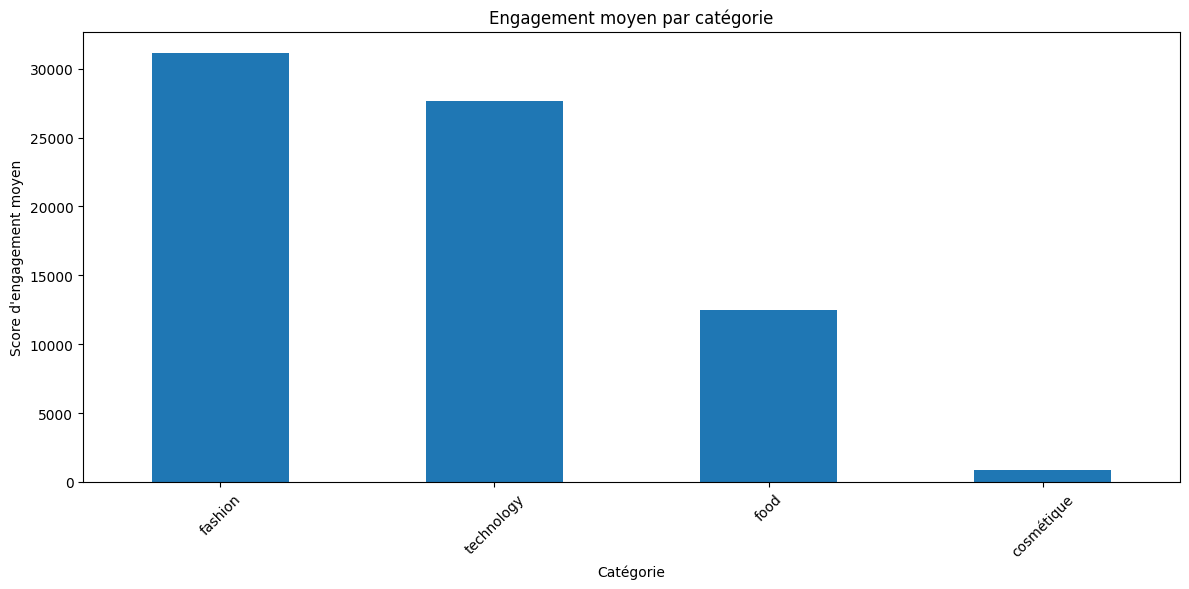

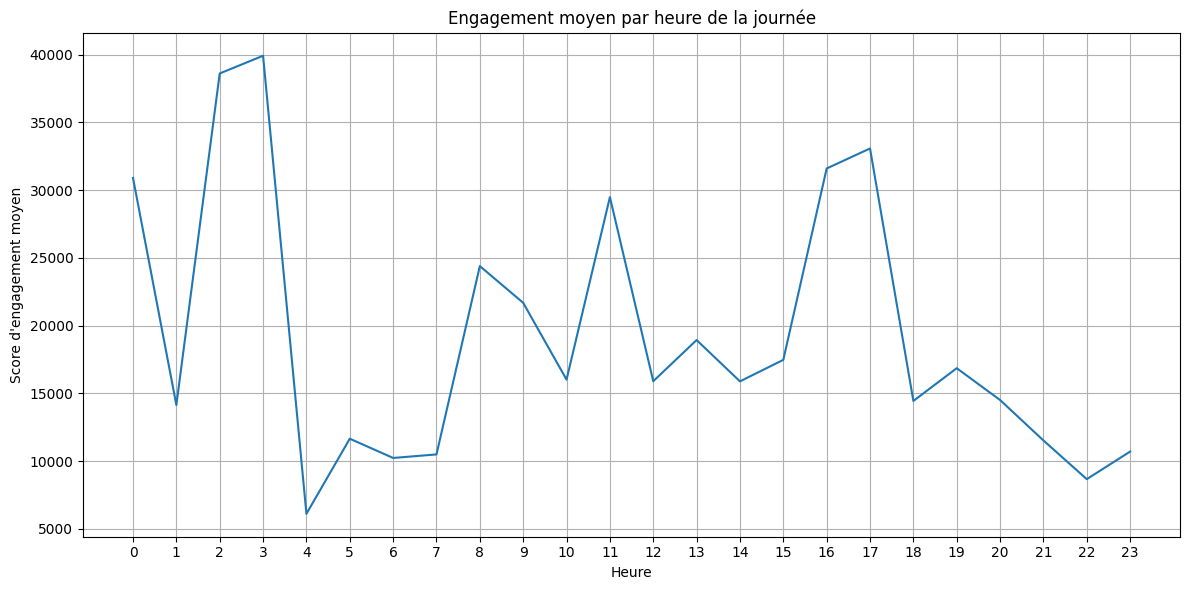

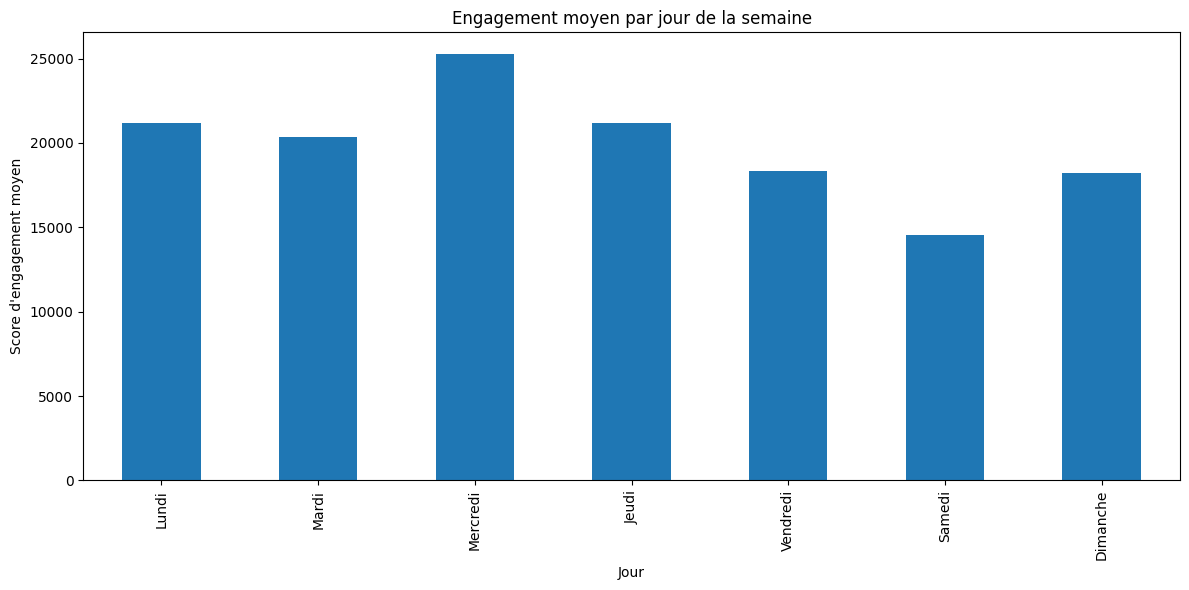

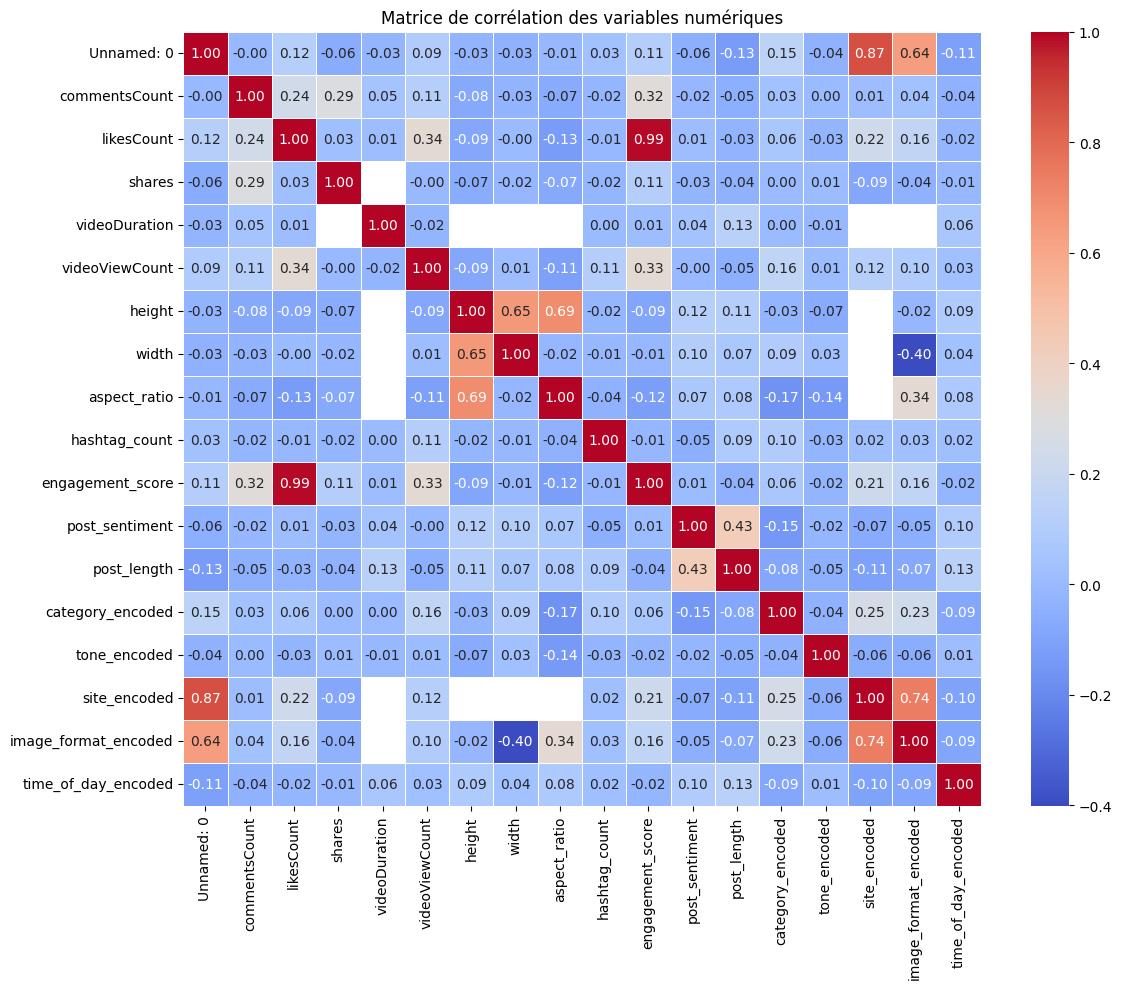

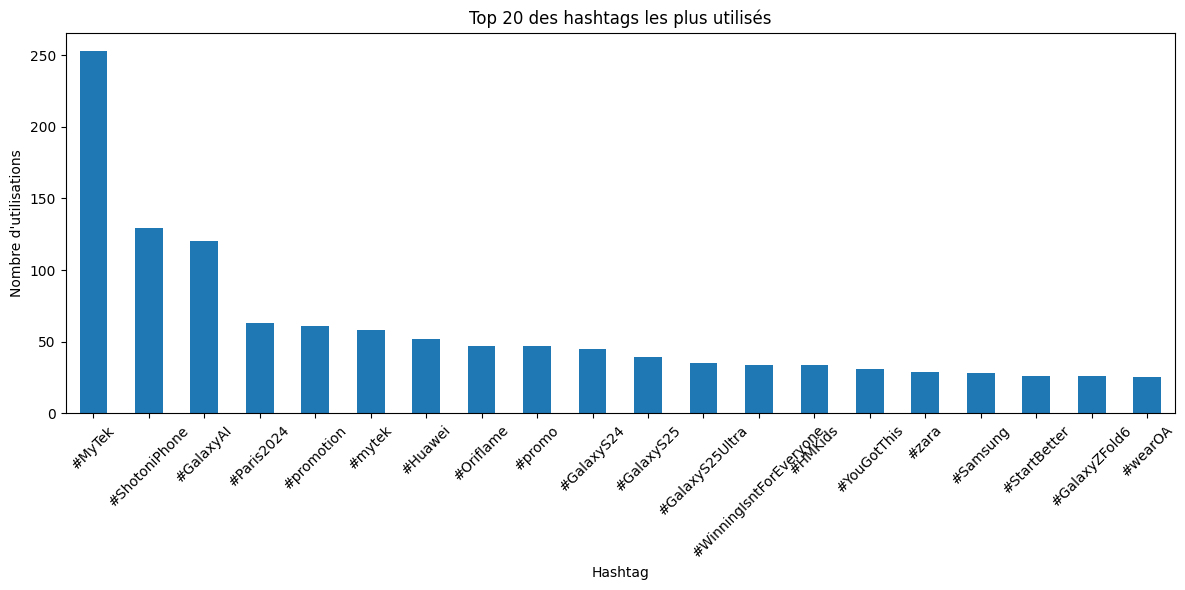

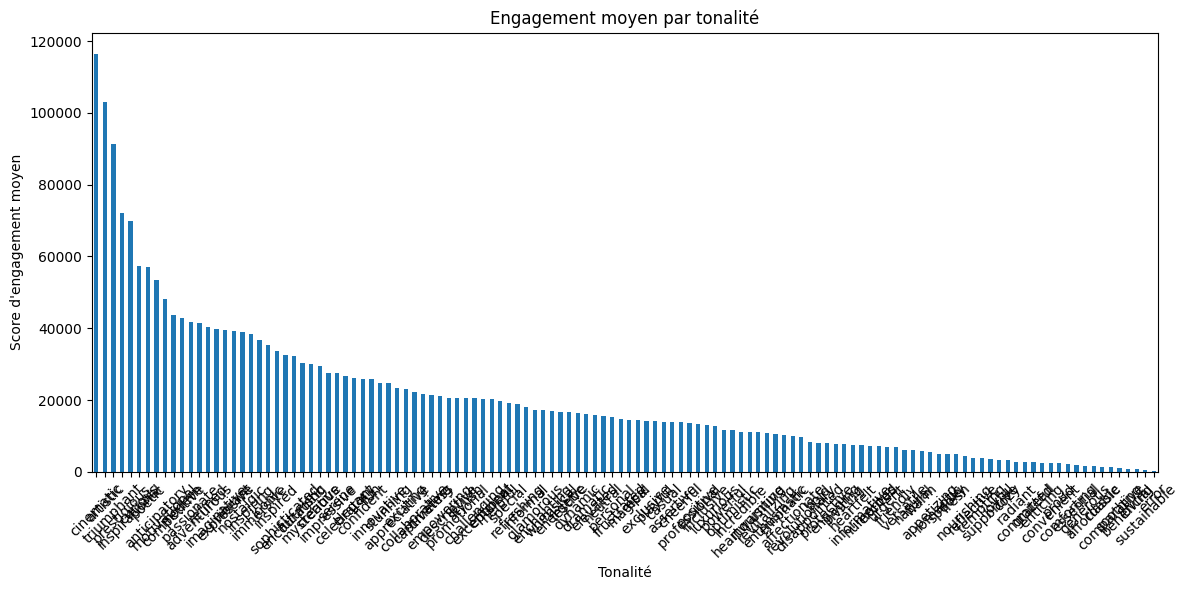

In [5]:
# 1. Visualiser l'engagement par catégorie
plt.figure(figsize=(12, 6))
engagement_by_category = df.groupby('category')['engagement_score'].mean().sort_values(ascending=False).head(10)
engagement_by_category.plot(kind='bar')
plt.title('Engagement moyen par catégorie')
plt.xlabel('Catégorie')
plt.ylabel('Score d\'engagement moyen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Engagement par heure de la journée
plt.figure(figsize=(12, 6))
engagement_by_hour = df.groupby('hour')['engagement_score'].mean()
engagement_by_hour.plot()
plt.title('Engagement moyen par heure de la journée')
plt.xlabel('Heure')
plt.ylabel('Score d\'engagement moyen')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Engagement par jour de la semaine
plt.figure(figsize=(12, 6))
day_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
engagement_by_day = df.groupby('day_of_week')['engagement_score'].mean()
engagement_by_day.index = day_names[:len(engagement_by_day)]
engagement_by_day.plot(kind='bar')
plt.title('Engagement moyen par jour de la semaine')
plt.xlabel('Jour')
plt.ylabel('Score d\'engagement moyen')
plt.tight_layout()
plt.show()

# 4. Corrélation entre variables numériques
plt.figure(figsize=(12, 10))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.show()

# 5. Analyse des hashtags les plus populaires
all_hashtags = [tag for tags_list in df['hashtags'] for tag in tags_list if isinstance(tags_list, list)]
hashtag_counts = pd.Series(all_hashtags).value_counts()
top_hashtags = hashtag_counts.head(20)

plt.figure(figsize=(12, 6))
top_hashtags.plot(kind='bar')
plt.title('Top 20 des hashtags les plus utilisés')
plt.xlabel('Hashtag')
plt.ylabel('Nombre d\'utilisations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Relation entre tonalité et engagement
tone_engagement = df.groupby('tone')['engagement_score'].agg(['mean', 'count']).sort_values('mean', ascending=False)
tone_engagement = tone_engagement[tone_engagement['count'] > 10]  # Filtrer pour avoir assez d'échantillons

plt.figure(figsize=(12, 6))
tone_engagement['mean'].plot(kind='bar')
plt.title('Engagement moyen par tonalité')
plt.xlabel('Tonalité')
plt.ylabel('Score d\'engagement moyen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [7]:
pip install streamlit pandas numpy scikit-learn transformers datasets torch matplotlib seaborn plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.

In [8]:
!pip install pandas numpy scikit-learn transformers datasets torch streamlit pyngrok --quiet

In [11]:
# Supprimer les anciens fichiers
!rm -f marketing_tool_improved_v5.py

# Écrire le fichier de l'app
with open("marketing_tool_improved_v5.py", "w") as f:
    f.write('''
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, MarianMTModel, MarianTokenizer
from transformers.utils import logging as transformers_logging
from datasets import Dataset
import streamlit as st
import torch
import warnings
import pickle
import os
import requests
import tweepy
from typing import Dict, List, Optional

# Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
transformers_logging.set_verbosity_error()
warnings.filterwarnings('ignore')
np.random.seed(42)

# Constantes
CATEGORIES = ['food', 'fashion', 'beauty', 'tech', 'lifestyle']
TONES = ['anticipatory', 'luxury', 'gourmand', 'authentique', 'inspirational', 'playful', 'professional']
PLATFORMS = ['instagram', 'facebook', 'tiktok', 'linkedin']
EMOTIONS = ['fierté', 'désir', 'douceur', 'joie', 'curiosité']
COPY_PATTERNS = ['AIDA', 'PAS', 'Storytelling']
LANGUAGES = ['français', 'anglais', 'arabe']

# Dictionnaire de traductions
TRANSLATIONS = {
    'français': {
        'title': '📈 Outil Marketing Tunisien',
        'product': 'Produit',
        'category': 'Catégorie',
        'platform': 'Plateforme',
        'tone': 'Tonalité',
        'emotion': 'Émotion',
        'price': 'Prix (TND)',
        'date': 'Date',  # Simplified for date_input
        'generate': 'Générer Recommandations',
        'summary': '📊 Résumé',
        'weekly_plan': '📅 Plan Hebdomadaire',
        'coach': '💬 Coach IA',
        'strategy': '🚀 Stratégie 360°',
        'budget_roi': '💸 Budget & ROI',
        'feedback': 'Engagement réel (%)',
        'submit_feedback': 'Soumettre Feedback',
        'feedback_success': 'Feedback enregistré !',
        'language': 'Langue'
    },
    'anglais': {
        'title': '📈 Tunisian Marketing Tool',
        'product': 'Product',
        'category': 'Category',
        'platform': 'Platform',
        'tone': 'Tone',
        'emotion': 'Emotion',
        'price': 'Price (TND)',
        'date': 'Date',
        'generate': 'Generate Recommendations',
        'summary': '📊 Summary',
        'weekly_plan': '📅 Weekly Plan',
        'coach': '💬 AI Coach',
        'strategy': '🚀 360° Strategy',
        'budget_roi': '💸 Budget & ROI',
        'feedback': 'Actual Engagement (%)',
        'submit_feedback': 'Submit Feedback',
        'feedback_success': 'Feedback saved!',
        'language': 'Language'
    },
    'arabe': {
        'title': '📈 أداة تسويق تونسية',
        'product': 'المنتج',
        'category': 'الفئة',
        'platform': 'المنصة',
        'tone': 'النبرة',
        'emotion': 'المشاعر',
        'price': 'السعر (دينار تونسي)',
        'date': 'التاريخ',
        'generate': 'إنشاء التوصيات',
        'summary': '📊 ملخص',
        'weekly_plan': '📅 الخطة الأسبوعية',
        'coach': '💬 المدرب الذكي',
        'strategy': '🚀 استراتيجية 360 درجة',
        'budget_roi': '💸 الميزانية وعائد الاستثمار',
        'feedback': 'التفاعل الفعلي (%)',
        'submit_feedback': 'إرسال التعليقات',
        'feedback_success': 'تم حفظ التعليقات!',
        'language': 'اللغة'
    }
}

# Météo simulée
WEATHER_CONDITIONS = {
    'Tunis': {'temp': np.random.randint(15, 35), 'condition': np.random.choice(['ensoleillé', 'nuageux', 'pluvieux'])}
}

# Historique des performances
PERFORMANCE_HISTORY_FILE = "performance_history.pkl"
def load_performance_history():
    logging.info("DEBUG: Chargement de l'historique des performances")
    if os.path.exists(PERFORMANCE_HISTORY_FILE):
        try:
            with open(PERFORMANCE_HISTORY_FILE, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            logging.error(f"Erreur lors du chargement de l'historique : {str(e)}")
            return []
    return []

def save_performance_history(history):
    logging.info("DEBUG: Sauvegarde de l'historique des performances")
    try:
        with open(PERFORMANCE_HISTORY_FILE, 'wb') as f:
            pickle.dump(history, f)
    except Exception as e:
        logging.error(f"Erreur lors de la sauvegarde de l'historique : {str(e)}")

PERFORMANCE_HISTORY = load_performance_history()

# Cache des modèles
MODEL_CACHE_DIR = "./model_cache"
os.makedirs(MODEL_CACHE_DIR, exist_ok=True)

# Fonction de traduction
def translate_text(text: str, target_lang: str) -> str:
    logging.info(f"DEBUG: Traduction du texte '{text}' vers {target_lang}")
    try:
        if target_lang == 'français':
            return text
        model_name = {
            'anglais': 'Helsinki-NLP/opus-mt-fr-en',
            'arabe': 'Helsinki-NLP/opus-mt-fr-ar'
        }.get(target_lang)
        if not model_name:
            logging.warning(f"DEBUG: Langue {target_lang} non supportée")
            return text
        tokenizer = MarianTokenizer.from_pretrained(model_name, cache_dir=MODEL_CACHE_DIR)
        model = MarianMTModel.from_pretrained(model_name, cache_dir=MODEL_CACHE_DIR)
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        translated = model.generate(**inputs)
        result = tokenizer.decode(translated[0], skip_special_tokens=True)
        logging.info(f"DEBUG: Traduction réussie : {result}")
        return result
    except Exception as e:
        logging.error(f"Erreur dans translate_text : {str(e)}")
        return text

# Générer texte avec Hugging Face (simulé)
def generate_text_huggingface(prompt: str, max_length: int = 100) -> str:
    logging.info(f"DEBUG: Génération texte statique pour prompt : {prompt}")
    try:
        product = prompt.split("pour '")[1].split("'")[0].strip()
        category = prompt.split("catégorie ")[1].split(".")[0].strip().lower()
    except:
        product = "ton produit"
        category = "default"
    texts = {
        "food": f"Savoure la vibe avec {product}, fierté des foodies stylées ! 🍕🔥",
        "fashion": f"Brille en {product}, queen de la mode tunisienne ! 👗✨",
        "beauty": f"Sublime ton éclat avec {product}, fierté des queens ! 💄💖",
        "lifestyle": f"Vis à fond avec {product}, vibe fière et libre ! 🌈😎",
        "tech": f"Domine avec {product}, tech queen au top ! 💻🚀",
        "default": f"Shine avec {product}, fierté des queens modernes ! 💪✨"
    }
    text = texts.get(category, texts["default"])
    if len(text) > max_length:
        text = text[:max_length-3] + "..."
    logging.info(f"DEBUG: Texte généré : {text}")
    return text

# Jours fériés tunisiens 2025
HOLIDAYS_TN_2025 = {
    "2025-01-01": {"name": "Jour de l'An", "theme": "nouvel an"},
    "2025-03-20": {"name": "Fête de l'Indépendance", "theme": "indépendance"},
    "2025-04-09": {"name": "Journée des Martyrs", "theme": "martyrs"},
    "2025-05-01": {"name": "Fête du Travail", "theme": "travail"},
    "2025-06-01": {"name": "Aïd el-Fitr", "theme": "aïd el-fitr"},
    "2025-08-07": {"name": "Aïd el-Adha", "theme": "aïd el-adha"},
    "2025-07-25": {"name": "Fête de la République", "theme": "république"},
    "2025-08-13": {"name": "Journée de la Femme", "theme": "femme"},
    "2025-10-15": {"name": "Fête de l'Évacuation", "theme": "évacuation"},
    "2025-08-28": {"name": "Ras el-Am el-Hijri", "theme": "nouvel an hijri"}
}

def test_holiday_api(date: str, api_key: str = None, country: str = "TN") -> dict:
    logging.info(f"DEBUG: Vérification des jours fériés pour {date} en {country}")
    try:
        target_date = pd.to_datetime(date).strftime('%Y-%m-%d')
        holiday = HOLIDAYS_TN_2025.get(target_date)
        if holiday:
            logging.info(f"DEBUG: Jour férié trouvé : {holiday['name']}")
            return {"name": holiday['name'], "theme": holiday['theme']}
        logging.info("DEBUG: Aucun jour férié trouvé")
        return {"name": None, "theme": None}
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans test_holiday_api : {str(e)}")
        return {"name": None, "theme": None}

# Tendances Twitter/X
def get_twitter_trends(woeid: str = "23424977", category: str = "beauty") -> List[str]:
    logging.info(f"DEBUG: Récupération des tendances Twitter pour WOEID {woeid}, catégorie {category}")
    try:
        bearer_token = "AAAAAAAAAAAAAAAAAAAAABVC0wEAAAAACD6o4b5d1oJEZycmT%2FORqNLRQkc%3DAetw6EH1bXe5Qd9ohI4lZce1p2rDZrfn2HjJxTTB0cDBi5dfY3"
        client = tweepy.Client(bearer_token=bearer_token)
        query = "(Tunisie OR Tunis OR Carthage OR Sfax OR Sousse) lang:fr -is:retweet"
        tweets = client.search_recent_tweets(query=query, max_results=10, tweet_fields=["entities"])
        if not tweets.data:
            logging.warning("DEBUG: Aucun tweet trouvé")
            return [f"#{category.capitalize()}Tunis", "#Tunisie2025"]
        hashtags = []
        for tweet in tweets.data:
            if tweet.entities and "hashtags" in tweet.entities:
                hashtags.extend([f"#{tag['tag']}" for tag in tweet.entities["hashtags"]])
        hashtag_counts = Counter(hashtags)
        trends_list = [hashtag for hashtag, count in hashtag_counts.most_common(5)]
        if not trends_list:
            logging.warning("DEBUG: Aucun hashtag trouvé")
            return [f"#{category.capitalize()}Tunis", "#Tunisie2025"]
        logging.info(f"DEBUG: Tendances récupérées : {trends_list}")
        return trends_list
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans get_twitter_trends : {str(e)}")
        return [f"#{category.capitalize()}Tunis", "#Tunisie2025"]

def get_current_event(date: pd.Timestamp) -> tuple:
    holiday = test_holiday_api(date.strftime('%Y-%m-%d'))
    return holiday['name'], holiday['theme'] if holiday['name'] else None

# Fine-tuner DistilBERT
def fine_tune_distilbert() -> tuple:
    logging.info("DEBUG: Début de fine_tune_distilbert")
    cache_path = os.path.join(MODEL_CACHE_DIR, "distilbert_tone.pkl")
    if os.path.exists(cache_path):
        try:
            with open(cache_path, 'rb') as f:
                logging.info("DEBUG: Chargement du modèle DistilBERT depuis le cache")
                return pickle.load(f)
        except:
            logging.warning("DEBUG: Cache corrompu, retraining DistilBERT")

    try:
        data = pd.DataFrame([
            {"text": "Crêpe tunisienne savoureuse", "tone": "gourmand"},
            {"text": "Collier artisanal élégant", "tone": "luxury"},
            {"text": "PC gamer ultra-puissant", "tone": "professional"},
            {"text": "Lipstick vibrant pour soirées", "tone": "playful"},
            {"text": "Inspire avec ce bijou unique", "tone": "inspirational"},
            {"text": "Couscous authentique tunisien", "tone": "authentique"},
            {"text": "Anticipe le nouveau parfum", "tone": "anticipatory"}
        ] * 20)

        dataset = Dataset.from_pandas(data)
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

        def tokenize_function(examples):
            return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

        tokenized_dataset = dataset.map(tokenize_function, batched=True)
        tone_to_id = {tone: idx for idx, tone in enumerate(TONES)}
        tokenized_dataset = tokenized_dataset.map(lambda x: {'labels': tone_to_id[x['tone']]})
        train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
        train_dataset = train_test_split['train']
        eval_dataset = train_test_split['test']

        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(TONES))
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=5,
            per_device_train_batch_size=8,
            warmup_steps=10,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=5,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            report_to="none"
        )

        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=-1)
            accuracy = (predictions == labels).mean()
            return {"accuracy": accuracy}

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            compute_metrics=compute_metrics
        )
        trainer.train()

        with open(cache_path, 'wb') as f:
            pickle.dump((model, tokenizer), f)
        logging.info("DEBUG: DistilBERT fine-tuné et sauvegardé")
        return model, tokenizer
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans fine_tune_distilbert : {str(e)}")
        return None, None

# Classifier la tonalité
def classify_tone(product: str, category: str, emotion: str) -> str:
    logging.info(f"DEBUG: Classification de la tonalité pour {product}, {category}, {emotion}")
    try:
        model, tokenizer = fine_tune_distilbert()
        if model is None or tokenizer is None:
            logging.warning("DEBUG: Échec du chargement du modèle DistilBERT")
            return 'authentique'
        text = f"Produit: {product}, Catégorie: {category}, Émotion: {emotion}"
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
        result = TONES[predicted_class]
        logging.info(f"DEBUG: Tonalité prédite : {result}")
        return result
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans classify_tone : {str(e)}")
        return 'authentique'

# Clustering des utilisateurs
def cluster_users(category: str) -> Dict:
    logging.info(f"DEBUG: Clustering des utilisateurs pour {category}")
    try:
        np.random.seed(42)
        n_samples = 1000
        data = pd.DataFrame({
            'age': np.random.randint(18, 65, n_samples),
            'income': np.random.randint(500, 5000, n_samples),
            'engagement': np.random.uniform(0.5, 10, n_samples),
            'category_interest': [category] * n_samples
        })

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(data[['age', 'income', 'engagement']])
        kmeans = KMeans(n_clusters=3, random_state=42)
        data['cluster'] = kmeans.fit_predict(X_scaled)

        clusters = {
            0: {'name': f"{category.capitalize()} Luxe", 'hours': [19, 20], 'hashtags': ['#TunisianElite', '#LuxeTunisien']},
            1: {'name': f"{category.capitalize()} Budget", 'hours': [12, 13], 'hashtags': ['#TunisianVibes', '#BonPlan']},
            2: {'name': f"{category.capitalize()} Casual", 'hours': [17, 18], 'hashtags': ['#TunisianStyle', '#DailyVibes']}
        }
        result = clusters[data['cluster'].mode()[0]]
        logging.info(f"DEBUG: Cluster sélectionné : {result['name']}")
        return result
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans cluster_users : {str(e)}")
        return {'name': f"{category.capitalize()} Budget", 'hours': [12, 13], 'hashtags': ['#TunisianVibes']}

# Générer des hashtags
def generate_hashtags(product: str, category: str, cluster: Dict, event: Optional[str] = None, lang: str = 'français') -> tuple:
    logging.info(f"DEBUG: Génération des hashtags pour {product}, {category}, event={event}, lang={lang}")
    try:
        base_hashtags = {
            'food': ['#TunisianFood', '#CuisineTunisienne', '#TunisianSweets'],
            'fashion': ['#BijouTunisien', '#ModeTunisienne', '#EléganceNaturelle'],
            'beauty': ['#TunisianBeauty', '#BeautéTunisienne'],
            'tech': ['#TechTunis', '#InnovationTunisienne', '#GamingTunis'],
            'lifestyle': ['#TunisianLifestyle', '#VieTunisienne']
        }
        hashtags = base_hashtags.get(category, ['#TunisianVibes']) + cluster['hashtags']
        if event:
            event_hashtags = {
                'Ramadan': ['#RamadanKareem', '#IftarVibes'],
                'Eid al-Fitr': ['#EidMubarak', '#TunisianEid'],
                'Summer Festival': ['#TunisianSummer', '#BeachVibes'],
                'Independence Day': ['#TunisianPride', '#IndependenceDay']
            }
            hashtags.extend(event_hashtags.get(event, []))
        hashtags.append(f"#{product.replace(' ', '')}")
        twitter_trends = get_twitter_trends(category=category)
        hashtags.extend([trend for trend in twitter_trends if trend.startswith('#')][:2])
        if lang != 'français':
            hashtags = [translate_text(tag, lang) for tag in hashtags]
        analysis = [{'hashtag': tag, 'reach': np.random.randint(10000, 100000)} for tag in hashtags[:5]]
        logging.info(f"DEBUG: Hashtags générés : {hashtags[:5]}")
        return hashtags[:5], analysis
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans generate_hashtags : {str(e)}")
        return ['#TunisianVibes'], [{'hashtag': '#TunisianVibes', 'reach': 10000}]

# Générer une description
def generate_post_description(product: str, category: str, tone: str, emotion: str, cluster_name: str, pattern: str, event: Optional[str] = None, lang: str = 'français') -> tuple:
    logging.info(f"DEBUG: Génération de la description pour {product}, {category}, {tone}, {emotion}")
    try:
        prompt = (
            f"Crée un post Instagram pour '{product}', catégorie {category} tunisienne. "
            f"Ton : {tone}. Émotion : {emotion}. Cible : {cluster_name}. Style : {pattern}. "
        )
        if event:
            prompt += f"Inclut le thème '{event}'. "
        prompt += (
            f"Mets en avant une caractéristique unique (ex. : texture douce). "
            f"Inclus un appel à l'action clair (ex. : Découvrez maintenant !). "
            f"Maximum 100 caractères. Langue : français."
        )

        desc = generate_text_huggingface(prompt, max_length=120)
        if not desc or desc == "Erreur : texte vide":
            desc = f"{product} : {emotion} pour {event or 'tous'} !"
            cta = f"Découvrez {product.lower()} !"
        else:
            if "!" in desc:
                desc_parts = desc.rsplit("!", 1)
                desc = desc_parts[0].strip()
                cta = desc_parts[1].strip() or f"Découvrez {product.lower()} !"
            else:
                desc = desc.strip()
                cta = f"Découvrez {product.lower()} !"
            desc = desc[:80] + ("..." if len(desc) > 80 else "")

        if lang != 'français':
            desc = translate_text(desc, lang)
            cta = translate_text(cta, lang)

        logging.info(f"DEBUG: Description générée : {desc} | CTA : {cta}")
        return desc, cta
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans generate_post_description : {str(e)}")
        return f"{product} : {emotion} pour {event or 'tous'} !", f"Découvrez {product.lower()} !"

# Générer un mood board
def generate_mood_board(category: str, tone: str, emotion: str) -> Dict:
    logging.info(f"DEBUG: Génération du mood board pour {category}, {tone}, {emotion}")
    try:
        mood_boards = {
            'food': {'colors': ['orange', 'red'], 'textures': ['rustique', 'chaud'], 'vibes': 'gourmand'},
            'fashion': {'colors': ['gold', 'white'], 'textures': ['soyeux', 'artisanat'], 'vibes': 'élégant'},
            'beauty': {'colors': ['pink', 'pastel'], 'textures': ['lisse', 'brillant'], 'vibes': 'glow'},
            'tech': {'colors': ['blue', 'black'], 'textures': ['futuriste', 'métallique'], 'vibes': 'innovant'},
            'lifestyle': {'colors': ['green', 'beige'], 'textures': ['naturel', 'doux'], 'vibes': 'authentique'}
        }
        base = mood_boards.get(category, {'colors': ['neutral'], 'textures': ['simple'], 'vibes': 'générique'})
        if tone == 'luxury':
            base['colors'].append('gold')
        if emotion == 'fierté':
            base['vibes'] += ', patriotique'
        logging.info(f"DEBUG: Mood board généré : {base}")
        return base
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans generate_mood_board : {str(e)}")
        return {'colors': ['neutral'], 'textures': ['simple'], 'vibes': 'générique'}

# Générer un visuel
def generate_ai_visual(product: str, category: str, tone: str, emotion: str, event: Optional[str] = None, lang: str = 'français') -> Dict:
    logging.info(f"DEBUG: Génération du visuel pour {product}, {category}, {tone}, {emotion}")
    try:
        mood = generate_mood_board(category, tone, emotion)
        desc = f"Visuel pour {product} ({category}) : ambiance {mood['vibes']}, couleurs {', '.join(mood['colors'])}, textures {', '.join(mood['textures'])}."
        if event:
            event_elements = {
                'Ramadan': ', table d’iftar, lanternes',
                'Eid al-Fitr': ', décor festif, douceurs',
                'Summer Festival': ', plage, soleil',
                'Independence Day': ', drapeau tunisien'
            }
            desc += event_elements.get(event, f', thème {event.lower()}')
        desc += f" Texte superposé : 'Vivez {emotion} avec {product} ✨'"
        if lang != 'français':
            desc = translate_text(desc, lang)
        logging.info(f"DEBUG: Visuel généré : {desc}")
        return {'visual_description': desc, 'mood_board': mood}
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans generate_ai_visual : {str(e)}")
        return {'visual_description': f"Visuel pour {product}", 'mood_board': {}}

# Recommander le format
def recommend_format(category: str, platform: str, lang: str = 'français') -> Dict:
    logging.info(f"DEBUG: Recommandation du format pour {category}, {platform}")
    try:
        formats = {
            'instagram': {
                'food': {'type': 'Carrousel', 'desc': 'Photos de recettes + étapes'},
                'fashion': {'type': 'Reel', 'desc': 'Vidéo de styling avec musique tendance'},
                'beauty': {'type': 'Story', 'desc': 'Tutoriel rapide avec swipe-up'},
                'tech': {'type': 'Reel', 'desc': 'Unboxing ou démo performance'},
                'lifestyle': {'type': 'Carrousel', 'desc': 'Moments de vie avec produit'}
            },
            'facebook': {
                'food': {'type': 'Post', 'desc': 'Image appétissante + lien recette'},
                'fashion': {'type': 'Album', 'desc': 'Collection de looks'},
                'beauty': {'type': 'Video', 'desc': 'Tutoriel détaillé'},
                'tech': {'type': 'Post', 'desc': 'Visuel tech + specs'},
                'lifestyle': {'type': 'Post', 'desc': 'Histoire culturelle'}
            }
        }
        format_rec = formats.get(platform, formats['instagram']).get(category, {'type': 'Post', 'desc': 'Image générique'})
        if lang != 'français':
            format_rec = {
                'type': translate_text(format_rec['type'], lang),
                'desc': translate_text(format_rec['desc'], lang)
            }
        logging.info(f"DEBUG: Format recommandé : {formatagrant_rec}")
        return format_rec
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans recommend_format : {str(e)}")
        return {'type': 'Post', 'desc': 'Image générique'}

# Prédire l’engagement
def predict_engagement(category: str, tone: str, platform: str, hour: float, model: RandomForestRegressor, scaler: StandardScaler) -> Dict:
    logging.info(f"DEBUG: Prédiction de l'engagement pour {category}, {tone}, {platform}, hour={hour}")
    try:
        data = pd.DataFrame({
            'hour': [hour],
            'category': [CATEGORIES.index(category)],
            'tone': [TONES.index(tone)],
            'platform': [PLATFORMS.index(platform)],
            'hashtag_engagement': [np.random.uniform(1, 3)]
        })
        X = scaler.transform(data)
        engagement = model.predict(X)[0]
        result = {
            'predicted_engagement': round(engagement, 1),
            'reach': int(engagement * 10000),
            'impressions': int(engagement * 15000),
            'interactions': int(engagement * 500)
        }
        logging.info(f"DEBUG: Engagement prédit : {result}")
        return result
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans predict_engagement : {str(e)}")
        return {'predicted_engagement': 1.0, 'reach': 10000, 'impressions': 15000, 'interactions': 500}

# Feedback loop
def update_performance_history(product: str, category: str, strategy: str, engagement: float) -> None:
    logging.info(f"DEBUG: Mise à jour de l'historique pour {product}, {category}, {strategy}, engagement={engagement}")
    try:
        PERFORMANCE_HISTORY.append({
            'product': product,
            'category': category,
            'strategy': strategy,
            'engagement': engagement,
            'timestamp': datetime.now()
        })
        save_performance_history(PERFORMANCE_HISTORY)
        logging.info(f"DEBUG: Performance ajoutée : {strategy} -> {engagement}%")
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans update_performance_history : {str(e)}")

# Générer un plan hebdomadaire
def generate_weekly_plan(product: str, category: str, tone: str, platform: str, cluster: Dict, lang: str = 'français') -> List[Dict]:
    logging.info(f"DEBUG: Génération du plan hebdomadaire pour {product}, {category}, {tone}, {platform}")
    try:
        plan = []
        base_date = pd.Timestamp.now()
        formats = ['Reel', 'Story', 'Carrousel', 'Post']
        for i in range(7):
            date = base_date + timedelta(days=i)
            event, _ = get_current_event(date)
            format_type = np.random.choice(formats)
            desc, cta = generate_post_description(product, category, tone, np.random.choice(EMOTIONS), cluster['name'], np.random.choice(COPY_PATTERNS), event, lang)
            plan.append({
                'date': date.strftime('%Y-%m-%d'),
                'format': translate_text(format_type, lang) if lang != 'français' else format_type,
                'description': desc,
                'cta': cta,
                'hour': np.random.choice(cluster['hours']),
                'priority': translate_text('À publier' if i < 3 else 'À planifier', lang)
            })
        logging.info(f"DEBUG: Plan hebdomadaire généré : {len(plan)} entrées")
        return plan
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans generate_weekly_plan : {str(e)}")
        return []

# Stratégie marketing
def get_tunisia_marketing_strategy(product: str, category: str, tone: str, cluster: Dict, emotion: str, event: Optional[str] = None, lang: str = 'français') -> Dict:
    logging.info(f"DEBUG: Génération de la stratégie pour {product}, {category}, {tone}, {emotion}")
    try:
        CATEGORY_STRATEGIES = {
            'food': [
                {'text': f"Reels recette avec {product}", 'score': 0.8},
                {'text': f"Défi dégustation #{product}", 'score': 0.7},
                {'text': f"Partenariat café local", 'score': 0.6},
                {'text': f"Foodie meetup Tunis", 'score': 0.5},
                {'text': f"Promo Ramadan pour {product}", 'score': 0.6}
            ],
            'fashion': [
                {'text': f"Reels styling {product}", 'score': 0.9},
                {'text': f"Défi look #{product}", 'score': 0.8},
                {'text': f"Pop-up shop Carthage", 'score': 0.7},
                {'text': f"Collab créateur local", 'score': 0.6},
                {'text': f"Live défilé Instagram", 'score': 0.5}
            ],
            'beauty': [
                {'text': f"Reels tuto {product}", 'score': 0.8},
                {'text': f"Quiz Stories teinte", 'score': 0.7},
                {'text': f"Défi beauté #{product}", 'score': 0.6},
                {'text': f"Giveaway 100 acheteurs", 'score': 0.5},
                {'text': f"Atelier makeup Tunis", 'score': 0.5}
            ],
            'tech': [
                {'text': f"Reels unboxing {product}", 'score': 0.9},
                {'text': f"Tournoi gaming", 'score': 0.8},
                {'text': f"Live Q&A tech", 'score': 0.7},
                {'text': f"Demo magasin Tunis", 'score': 0.6},
                {'text': f"Promo précommande", 'score': 0.5}
            ],
            'lifestyle': [
                {'text': f"Posts culturels {product}", 'score': 0.7},
                {'text': f"Vlog intégration {product}", 'score': 0.6},
                {'text': f"Marché local Tunis", 'score': 0.5},
                {'text': f"Sondage Stories", 'score': 0.5},
                {'text': f"Podcast sponsorisé", 'score': 0.4}
            ]
        }

        strategies = CATEGORY_STRATEGIES.get(category, CATEGORY_STRATEGIES['lifestyle'])
        for strat in strategies:
            past_perf = [p['engagement'] for p in PERFORMANCE_HISTORY if p['strategy'] == strat['text']]
            if past_perf:
                strat['score'] *= (1 + np.mean(past_perf) / 100)
            if emotion == 'fierté':
                strat['score'] *= 1.1
            if cluster['name'].endswith('Luxe'):
                strat['score'] *= 1.2

        strategies = sorted(strategies, key=lambda x: x['score'], reverse=True)[:3]
        weather = WEATHER_CONDITIONS['Tunis']
        if weather['condition'] == 'pluvieux':
            strategies.append({'text': f"Promo pluie : -10% sur {product}", 'score': 0.6})

        strategy = {
            'campaign_name': f"Campagne {product}",
            'key_strategies': [s['text'] for s in strategies],
            'influenceur': f"Collab avec @{category}_influencer_tn",
            'promo': f"10-15% de réduction pour {cluster['name']}"
        }
        if lang != 'français':
            strategy = {
                'campaign_name': translate_text(strategy['campaign_name'], lang),
                'key_strategies': [translate_text(s, lang) for s in strategy['key_strategies']],
                'influenceur': translate_text(strategy['influenceur'], lang),
                'promo': translate_text(strategy['promo'], lang)
            }
        logging.info(f"DEBUG: Stratégie générée : {strategy}")
        return strategy
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans get_tunisia_marketing_strategy : {str(e)}")
        return {'campaign_name': f"Campagne {product}", 'key_strategies': [], 'influenceur': '', 'promo': ''}

# Fonction principale
def recommend_post_format(
    product: str,
    category: str,
    tone: str = 'auto',
    platform: str = 'instagram',
    emotion: str = 'joie',
    base_price: Optional[float] = None,
    date: Optional[pd.Timestamp] = None,
    lang: str = 'français'
) -> Dict:
    logging.info(f"DEBUG: Début de recommend_post_format pour {product}, {category}, {tone}, {platform}")
    if not date:
        date = pd.Timestamp.now()

    try:
        if not product or category not in CATEGORIES:
            raise ValueError("Produit vide ou catégorie invalide")

        cluster = cluster_users(category)
        if tone == 'auto':
            tone = classify_tone(product, category, emotion)

        event, event_info = get_current_event(date)
        hashtags, hashtag_analysis = generate_hashtags(product, category, cluster, event, lang)
        desc, cta = generate_post_description(product, category, tone, emotion, cluster['name'], np.random.choice(COPY_PATTERNS), event, lang)
        visual = generate_ai_visual(product, category, tone, emotion, event, lang)
        format_rec = recommend_format(category, platform, lang)
        strategy = get_tunisia_marketing_strategy(product, category, tone, cluster, emotion, event, lang)

        n_samples = 100
        X = np.random.rand(n_samples, 5)
        y = np.random.uniform(0.5, 5, n_samples) + (X[:, 0] > 0.7) * 2
        model = RandomForestRegressor(random_state=42).fit(X, y)
        scaler = StandardScaler().fit(X)
        engagement = predict_engagement(category, tone, platform, date.hour, model, scaler)

        weekly_plan = generate_weekly_plan(product, category, tone, platform, cluster, lang)

        budget = np.random.uniform(50, 500)
        roi = engagement['predicted_engagement'] * 2

        coach = f"💬 Coach IA : Super choix avec {product} ! Publiez un {format_rec['type']} à {cluster['hours'][0]}h pour capter {cluster['name']}. Utilisez l’émotion {emotion} pour un max d’impact !"
        if lang != 'français':
            coach = translate_text(coach, lang)

        result = {
            'tone': {'primary': tone, 'justification': translate_text(f"Adapté à {cluster['name']} et {emotion}", lang)},
            'content': {'description': desc, 'cta': cta, 'format': format_rec},
            'visual': visual,
            'hashtags': {'tags': hashtags, 'analysis': hashtag_analysis},
            'posting_time': {'hour': cluster['hours'][0], 'justification': translate_text(f"Optimal pour {cluster['name']}", lang)},
            'strategy': strategy,
            'engagement': engagement,
            'weekly_plan': weekly_plan,
            'budget_roi': {'budget': round(budget, 2), 'roi': f"{round(roi, 1)}%"},
            'coach': coach
        }
        logging.info("DEBUG: Recommandations générées avec succès")
        return result
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans recommend_post_format : {str(e)}")
        return {"error": translate_text(str(e), lang)}


# Configuration de la page en premier
st.set_page_config(page_title="Marketing Tunisien", layout="wide")

# Ensuite, tout le reste du code Streamlit
def marketing_dashboard():
    # Check if page config has been set to avoid duplicate calls
    if 'page_config_set' not in st.session_state:
        try:
            st.session_state['page_config_set'] = True
            logging.info("DEBUG: Page configuration set")
        except Exception as e:
            logging.error(f"DEBUG: Erreur lors de la configuration de la page : {str(e)}")
            st.error(f"Erreur de configuration : {str(e)}")
            return

    try:
        st.write("DEBUG 1 : Début du tableau de bord")
        lang = st.radio("Choisir une langue", LANGUAGES, index=0, key="lang_radio")
        logging.info(f"DEBUG: Langue sélectionnée via radio : {lang}")
        t = TRANSLATIONS.get(lang, TRANSLATIONS['français'])
        st.title(t['title'])
        # Le reste de ton code...


        col1, col2 = st.columns(2)
        with col1:
            product = st.text_input(t['product'], "Collier")
            category = st.selectbox(t['category'], CATEGORIES)
            platform = st.selectbox(t['platform'], PLATFORMS)
        with col2:
            tone = st.selectbox(t['tone'], ['auto'] + TONES)
            emotion = st.selectbox(t['emotion'], EMOTIONS)
            base_price = st.number_input(t['price'], min_value=0.0, value=45.0)
            date = st.date_input(t['date'], value=pd.to_datetime("2025-04-24"))
            date = pd.Timestamp(date)

        # Validate category and product
        if product.lower() in ["collier", "bijou", "bracelet"] and category != "fashion":
            st.warning(translate_text("Le produit semble appartenir à la catégorie 'fashion'. Voulez-vous changer ?", lang))

        if st.button(t['generate']):
            st.write("DEBUG 5 : Bouton cliqué, génération des recommandations...")
            logging.info("DEBUG: Bouton 'Générer' cliqué")
            with st.spinner(translate_text("Génération des recommandations en cours...", lang)):
                recs = recommend_post_format(product, category, tone, platform, emotion, base_price, date, lang=lang)
                holiday = test_holiday_api(date.strftime('%Y-%m-%d'))
            if "error" in recs:
                st.error(f"Erreur : {recs['error']}")
                logging.error(f"DEBUG: Erreur dans recommend_post_format : {recs['error']}")
                return

            st.header(t['summary'])
            st.write(f"**{t['product']}** : {product}")
            st.write(f"**{t['tone']}** : {recs['tone']['primary']} ({recs['tone']['justification']})")
            st.write(f"**Post** : {recs['content']['description']} | CTA : {recs['content']['cta']}")
            st.write(f"**Format** : {recs['content']['format']['type']} ({recs['content']['format']['desc']})")
            st.write(f"**Hashtags** : {', '.join(recs['hashtags']['tags'])}")
            st.write(f"**Heure** : {recs['posting_time']['hour']}h ({recs['posting_time']['justification']})")
            if holiday["name"]:
                st.write(f"**Jour férié** : {holiday['name']} ({holiday['theme']})")
            else:
                st.write(f"**Jour férié** : {translate_text('Aucun', lang)}")

            st.subheader("📈 Tendances Twitter/X")
            trends = get_twitter_trends(category=category)
            if trends:
                st.write(f"{translate_text('Top tendances en Tunisie', lang)} : {', '.join(trends)}")
            else:
                st.warning(translate_text("Impossible de récupérer les tendances Twitter. Utilisation de hashtags génériques.", lang))

            st.header(t['weekly_plan'])
            if recs['weekly_plan']:
                plan_df = pd.DataFrame(recs['weekly_plan'])
                st.table(plan_df)
            else:
                st.warning(translate_text("Aucun plan hebdomadaire généré.", lang))

            st.header(t['coach'])
            st.write(recs['coach'])

            st.header(t['strategy'])
            st.write(f"**Campagne** : {recs['strategy']['campaign_name']}")
            for strat in recs['strategy']['key_strategies']:
                st.write(f"- {strat}")
            st.write(f"**Influenceur** : {recs['strategy']['influenceur']}")
            st.write(f"**Promo** : {recs['strategy']['promo']}")

            st.header(t['budget_roi'])
            st.write(f"**Budget estimé** : {recs['budget_roi']['budget']} TND")
            st.write(f"**ROI prévu** : {recs['budget_roi']['roi']}")

            engagement = st.slider(t['feedback'], 0.0, 10.0, 5.0)
            if st.button(t['submit_feedback']):
                for strat in recs['strategy']['key_strategies']:
                    update_performance_history(product, category, strat, engagement)
                st.success(t['feedback_success'])
    except Exception as e:
        st.error(f"Erreur dans l'interface : {str(e)}")
        logging.error(f"DEBUG: Erreur dans marketing_dashboard : {str(e)}")

# Test unitaire
def test_marketing_tool():
    logging.info("DEBUG: Exécution des tests unitaires")
    try:
        recs = recommend_post_format("Pizza", "food", "authentique", "instagram", "fierté", 26.0)
        assert 'content' in recs, "Recommandations incomplètes"
        assert len(recs['weekly_plan']) == 7, "Plan hebdomadaire incorrect"
        assert len(recs['hashtags']['tags']) > 0, "Hashtags manquants"
        logging.info("DEBUG: Tests unitaires passés")
    except Exception as e:
        logging.error(f"DEBUG: Erreur dans test_marketing_tool : {str(e)}")

if __name__ == "__main__":
    logging.info("DEBUG: Lancement de l'application")
    marketing_dashboard()
''')
# Vérifier la syntaxe
!python -m py_compile marketing_tool_improved_v5.py

In [12]:
!pkill ngrok
from pyngrok import ngrok
import subprocess
import time
streamlit_cmd = "streamlit run marketing_tool_improved_v5.py --server.port 8501 &"
subprocess.Popen(streamlit_cmd, shell=True)
time.sleep(10)
public_url = ngrok.connect(8501)
print(f"Streamlit app is live at: {public_url}")

Streamlit app is live at: NgrokTunnel: "https://92a6-35-204-80-140.ngrok-free.app" -> "http://localhost:8501"
